<a href="https://colab.research.google.com/github/GollaChitraleka/FakeNews_Detection/blob/main/FakeNews_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fake news detection

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [4]:
fake = pd.read_csv("/content/Fake.csv")
true = pd.read_csv("/content/True.csv")

In [5]:
fake.shape

(23481, 4)

In [6]:
true.shape

(21417, 4)

Data cleaning and preparation

In [7]:
fake['target'] = 'fake'
true['target'] = 'true'

In [8]:
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [9]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [10]:
data.head()

,title,text,subject,date,target
0,Merkel says U.S. travel ban not justified by t...,BERLIN (Reuters) - Chancellor Angela Merkel sa...,politicsNews,"January 30, 2017",true
1,Japan ruling coalition seen winning around two...,TOKYO (Reuters) - Japanese Prime Minister Shin...,worldnews,"October 18, 2017",true
2,TRUMP SLAMS OBAMA AND VOWS To Undo Cuban Policy,Last year Obama added an action to his manifes...,politics,"Sep 18, 2016",fake
3,"U.S., Germany eye ways to deepen cyber collabo...",WASHINGTON (Reuters) - Senior U.S. and German ...,politicsNews,"March 24, 2016",true
4,White House chiefs of staff welcome new member...,WASHINGTON (Reuters) - Eleven men who have hel...,politicsNews,"December 16, 2016",true


In [11]:
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Merkel says U.S. travel ban not justified by t...,BERLIN (Reuters) - Chancellor Angela Merkel sa...,politicsNews,true
1,Japan ruling coalition seen winning around two...,TOKYO (Reuters) - Japanese Prime Minister Shin...,worldnews,true
2,TRUMP SLAMS OBAMA AND VOWS To Undo Cuban Policy,Last year Obama added an action to his manifes...,politics,fake
3,"U.S., Germany eye ways to deepen cyber collabo...",WASHINGTON (Reuters) - Senior U.S. and German ...,politicsNews,true
4,White House chiefs of staff welcome new member...,WASHINGTON (Reuters) - Eleven men who have hel...,politicsNews,true


In [12]:
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,BERLIN (Reuters) - Chancellor Angela Merkel sa...,politicsNews,true
1,TOKYO (Reuters) - Japanese Prime Minister Shin...,worldnews,true
2,Last year Obama added an action to his manifes...,politics,fake
3,WASHINGTON (Reuters) - Senior U.S. and German ...,politicsNews,true
4,WASHINGTON (Reuters) - Eleven men who have hel...,politicsNews,true


In [13]:
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()


,text,subject,target
0,berlin (reuters) - chancellor angela merkel sa...,politicsNews,true
1,tokyo (reuters) - japanese prime minister shin...,worldnews,true
2,last year obama added an action to his manifes...,politics,fake
3,washington (reuters) - senior u.s. and german ...,politicsNews,true
4,washington (reuters) - eleven men who have hel...,politicsNews,true


In [14]:
import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [15]:
data.head()

,text,subject,target
0,berlin reuters chancellor angela merkel said ...,politicsNews,true
1,tokyo reuters japanese prime minister shinzo ...,worldnews,true
2,last year obama added an action to his manifes...,politics,fake
3,washington reuters senior us and german offic...,politicsNews,true
4,washington reuters eleven men who have held w...,politicsNews,true


In [16]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
data.head()

,text,subject,target
0,berlin reuters chancellor angela merkel said g...,politicsNews,true
1,tokyo reuters japanese prime minister shinzo a...,worldnews,true
2,last year obama added action manifesto would f...,politics,fake
3,washington reuters senior us german officials ...,politicsNews,true
4,washington reuters eleven men held considered ...,politicsNews,true


subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


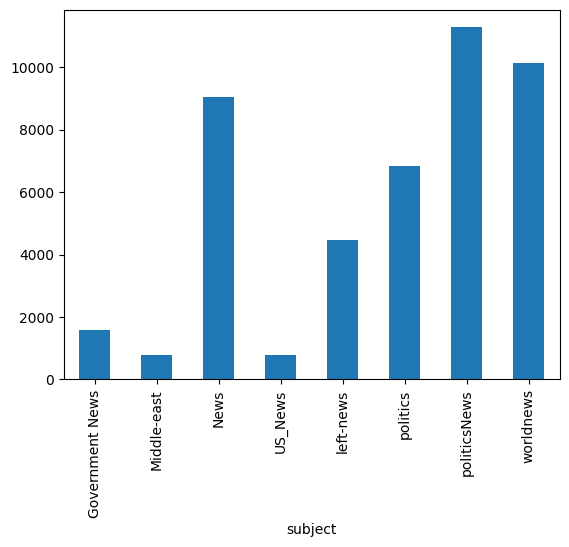

In [18]:
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


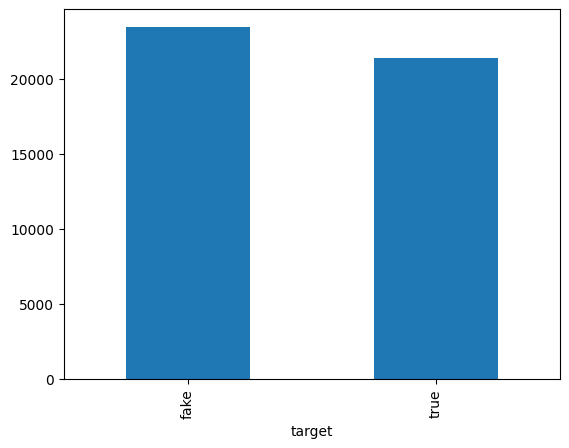

In [19]:
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()


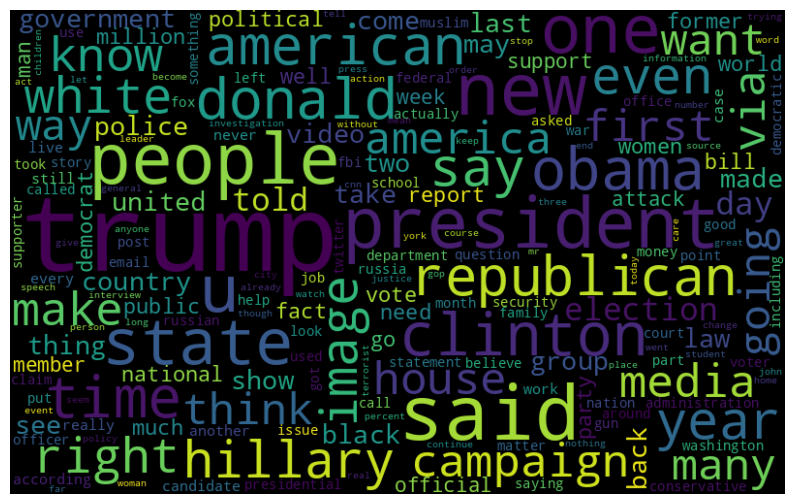

In [20]:
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


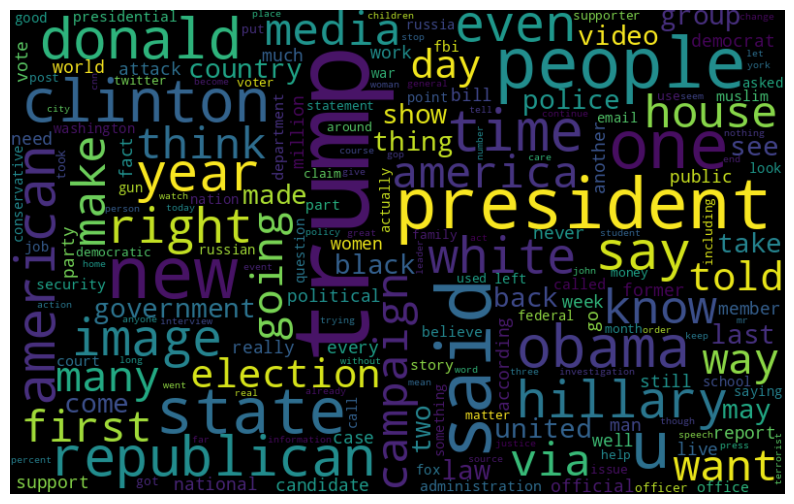

In [21]:
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

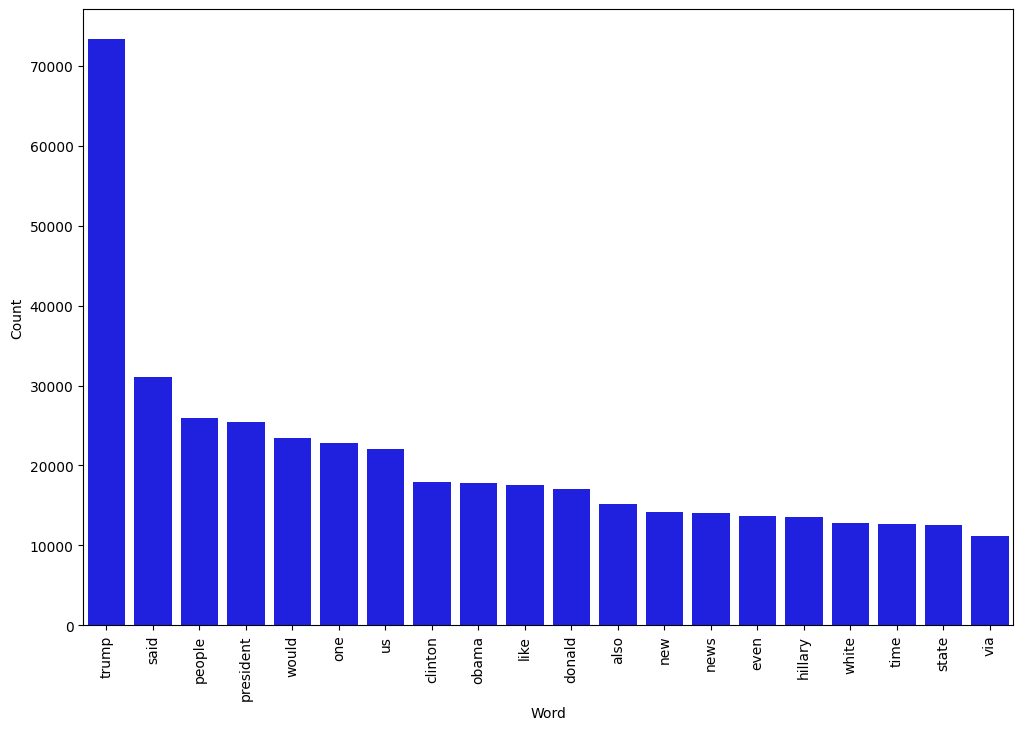

In [23]:
counter(data[data["target"] == "fake"], "text", 20)

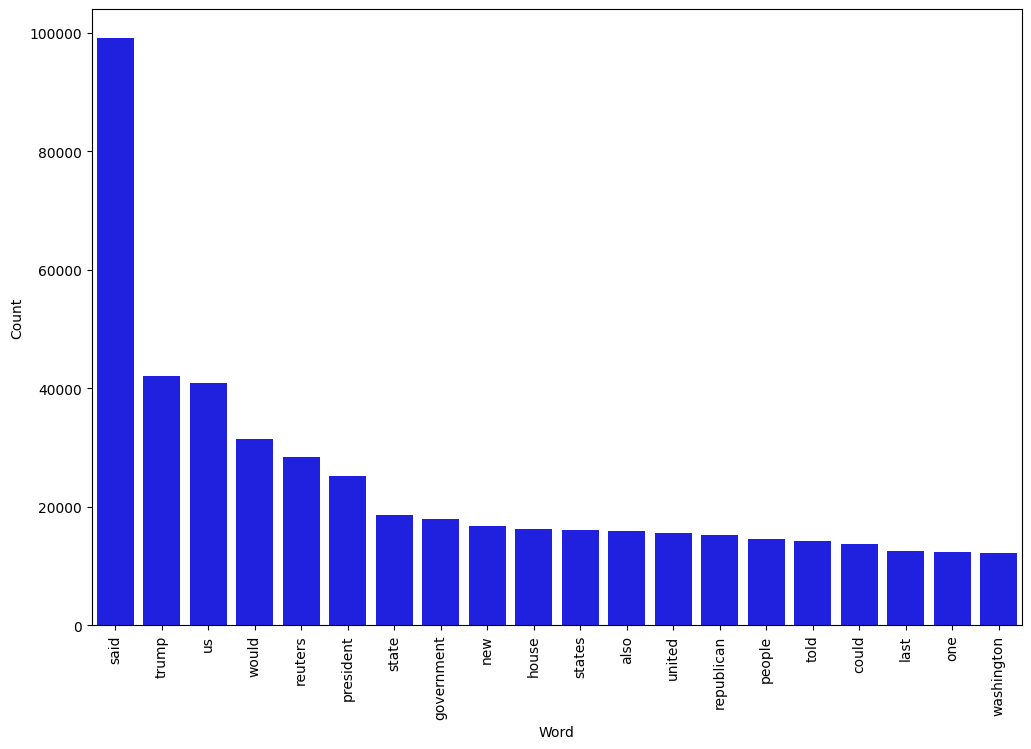

In [24]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

Modeling

In [25]:
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Peparing the data

In [26]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

Logistic regression

In [27]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.76%


Confusion matrix, without normalization


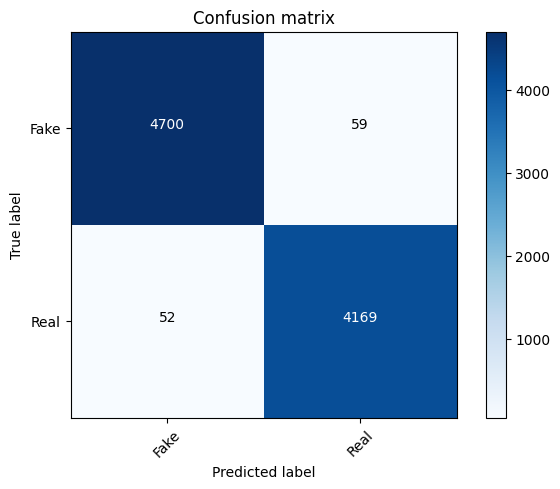

In [28]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

Decision Tree Classifier

In [29]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20,
                                           splitter='best',
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.62%


Confusion matrix, without normalization


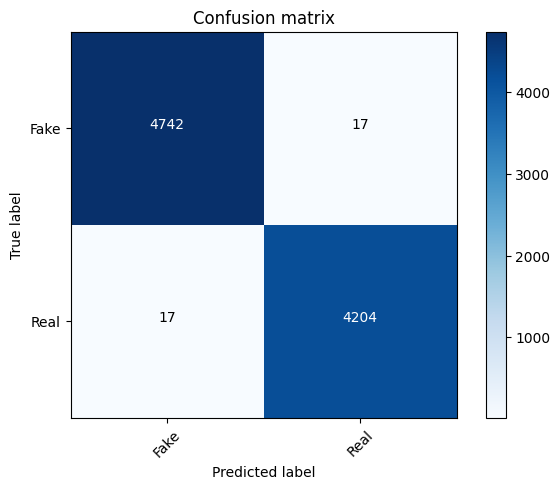

In [30]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

Random Forest Classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.0%


Confusion matrix, without normalization


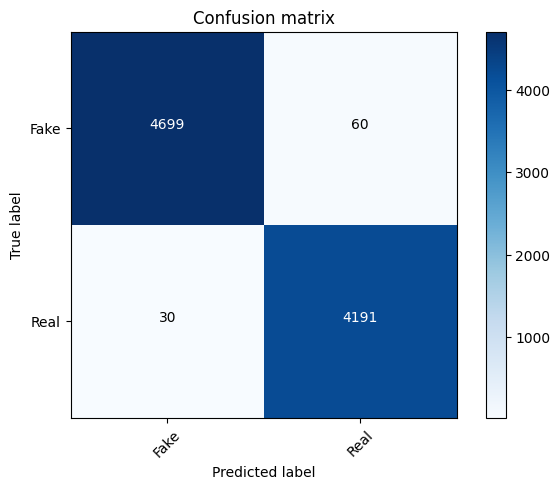

In [32]:

cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])